## 1. Headers and Imports

In [252]:
# Computational Libraries
import tensorflow as tf
import numpy as np
import pandas as pd

# Train Test Split
from sklearn.model_selection import train_test_split

# Tensorflow Modelling Imports
from tensorflow.nn import relu, sigmoid

# Keras Callbacks
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Metric Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from IPython.display import display, clear_output

%matplotlib inline

## 2. Bolier Code

In [253]:
# Data Importing
df = pd.read_csv("./Processed_Data/titanic/train.csv", dtype=np.dtype("float32"))
display(df.head())

# Features and Labels
labels = df["Survived"]
features = df.drop(columns= ["Survived"])

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.250000,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.283302,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.925000,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.099998,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.050000,0.0,1.0,0.0,0.0,1.0


### Vectorize Input Data

In [254]:
def verctorizeData(X,Y):
    X_flattened = tf.transpose(tf.reshape(X,(X.shape[0],-1)))
    Y_flattened = tf.transpose(tf.reshape(Y,(Y.shape[0],-1)))
    return  X_flattened,Y_flattened

In [255]:
X_train, X_test, Y_train, Y_test = train_test_split(features,labels,test_size = 0.1, random_state = 33)
print(f"Shape of Training Set \n X_Train : {X_train.shape}\n Y_Train : {Y_train.shape}")
print(f"Shape of Evaluation Set \n X_Train : {X_test.shape}\n Y_Train : {Y_test.shape}")

features,labels = verctorizeData(X_train,Y_train)
print(features.shape)
print(labels.shape)
# Data Split

Shape of Training Set 
 X_Train : (800, 10)
 Y_Train : (800,)
Shape of Evaluation Set 
 X_Train : (89, 10)
 Y_Train : (89,)
(10, 800)
(1, 800)


## 3. Modelling

### 3.1 Constants

In [267]:
learning_rate = 0.001
epochs = 1000
batch_size =128

n_x = 10
dims = [n_x,20,10,5,1]

# Regularization Parameter
lambd = 0.8

# Droupout parameter
dropOutList=[0,1,1,1,0]
keepProp = 0.8

epsilon = 1e-5

In [257]:
def sigmoidBackward(dA,Z):
    sigmoid_val = sigmoid(Z)
    return sigmoid_val*(1-sigmoid_val)*dA

def reluBackward(dA, Z):
    Z = Z>0
    return dA*tf.cast(Z,dtype = tf.float32)

### Weight Intialization

In [258]:
def initializeParameters(dims):
    params = {}
    for i in range(1,len(dims)):
        params["W"+str(i)] = tf.random.normal((dims[i],dims[i-1]),dtype=tf.float32)*np.sqrt(2/dims[i-1])
        params["b" + str(i)] = tf.zeros((dims[i], 1),dtype=tf.float32)
    return  params

### Loss

In [259]:
# Calculate Loss
def cost(Y,AL,epsilon =1e-5):
    return (-1/Y.shape[1])*np.sum(np.multiply(Y,np.log(AL+epsilon))+np.multiply(1-Y,np.log(1-AL+epsilon)))

### Optimizer

In [260]:
def updateParameters(params,grads,learning_rate):
    L = len(params)//2
    parameters = params.copy()
    for i in range(1,L+1):
        parameters["W" + str(i)] = params["W" + str(i)] - learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] = params["b" + str(i)] - learning_rate * grads["db" + str(i)]

    return parameters


### Forward Propagation

In [261]:
def forwardPropogation(X, params, dropOutList, keepProp):
    cache = {}
    L = len(params) // 2
    cache["A0"] = X
    for i in range(1, L):
        cache["Z" + str(i)] = tf.tensordot(params["W" + str(i)], cache["A" + str(i - 1)], axes = 1) + params["b" + str(i)]
        cache["A" + str(i)] = tf.nn.relu(cache["Z" + str(i)])
        if (dropOutList[i] == 1):
            cache["D" + str(i)] = tf.random.normal(cache["A" + str(i)].shape[0], cache["A" + str(i)].shape[1]) < keepProp
            cache["A" + str(i)] = (cache["A" + str(i)] * cache["D" + str(i)]) / keepProp

    cache["Z" + str(L)] = tf.tensordot(params["W" + str(L)], cache["A" + str(L - 1)],  axes = 1) + params["b" + str(L)]
    cache["A" + str(L)] = sigmoid(cache["Z" + str(L)])

    return cache["A" + str(L)], cache

### Backward Propagation

In [262]:
def backwardPropogation(Y, AL, cache, params, lambd, dropOutList, keepProp):
    L = len(params) // 2
    m = Y.shape[1]
    dAL = -1 * (Y - AL)
    grads = {}
    grads["dA" + str(L)] = dAL
    grads["dZ" + str(L)] = sigmoidBackward(dAL, cache["Z" + str(L)])
    grads["dA" + str(L - 1)] = tf.tensordot(tf.transpose(params["W" + str(L)]), grads["dZ" + str(L)], axes = 1)
    grads["dW" + str(L)] = tf.tensordot(grads["dZ" + str(L)], tf.transpose(cache["A" + str(L - 1)]),axes = 1) / m + (lambd / m) * np.sum(
        params["W" + str(L)])
    grads["db" + str(L)] = np.sum(grads["dZ" + str(L)], axis=1, keepdims=True) / m

    for i in range(L - 1, 0, -1):
        grads["dZ" + str(i)] = reluBackward(grads["dA" + str(i)], cache["Z" + str(i)])

        if (i > 1):
            grads["dA" + str(i - 1)] = tf.tensordot(tf.transpose(params["W" + str(i)]), grads["dZ" + str(i)],axes = 1)
            if (dropOutList[i - 1] == 1):
                grads["dA" + str(i - 1)] = (grads["dA" + str(i - 1)] * cache["D" + str(i - 1)]) / keepProp

        grads["dW" + str(i)] = tf.tensordot(grads["dZ" + str(i)], tf.transpose(cache["A" + str(i - 1)]),axes = 1) / m + (lambd / m) * np.sum(
            params["W" + str(i)])
        grads["db" + str(i)] = np.sum(grads["dZ" + str(i)], axis=1, keepdims=True) / m
        
    return grads


### plotLiveCosts

In [263]:
def plotLiveCosts(values,x_l = "Iters", y_l = "Costs",title=""):
    clear_output(wait=True)
    plt.plot(np.squeeze(values))
    plt.ylabel(y_l)
    plt.xlabel(x_l)
    plt.title(title)
    plt.show()

### Batching

In [264]:
def makeBatches(X,Y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    shuffled_data = dataset.shuffle(1000).repeat()
#     batch_data = shuffled_data.batch(batch_size)
    return batch_data

### Defining Model

In [265]:
# Gets Gradients and Updates Parameters
def trainModel(X, Y, learningRate,epochs, batch_size, dims, lambd=0,dropOutList=[],keepProp = 1, params = []):
    if(params == []):
        params = initializeParameters(dims)
    if(dropOutList == []):
        dropOutList = np.zeros((len(dims)))
    costs = []
    if(costs == []):
        costs = []
    
    training_data = X, Y
    for i in range(epochs):
        for batch in training_data:

            
            
            AL, cache = forwardPropogation(X, params,dropOutList,keepProp)
            cost_val = cost(Y,AL)
            costs.append(cost_val)
            grads = backwardPropogation(Y, AL,cache,params,lambd,dropOutList,keepProp)
    #         # Debug
    #         print(".....................",i)
    #         print("params",":",params)
    #         print("cache", ":", cache)
    #         print("Grads", ":", grads)

            params = updateParameters(params,grads,learningRate)

            if(i%10 == 0):
                plotLiveCosts(costs)

    return params,costs

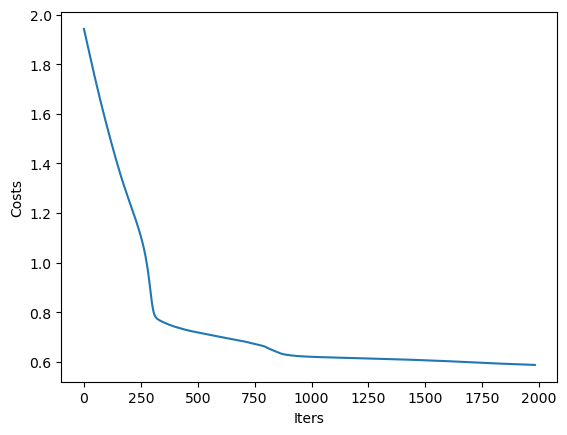

In [268]:
history = trainModel(features,labels, learning_rate,epochs, batch_size, dims, lambd=0,dropOutList=[],keepProp = 1, params = [])